# 树回归
主要内容：
> 1. CART算法
> 2. 回归与模型树
> 3. 树剪枝算法
> 4. Python GUI

## 1. 复杂数据的局部性建模
树回归算法：
> 优点：可以对复杂和非线性的数据建模<br>
> 缺点：结果不易理解<br>
> 适用数据类型：数值型和标称型数据

树回归的一般方法：
> 1. 收集数据：采用任意方法收集数据。
> 2. 准备数据：需要数值型的数据，标称型数据应该映射成二值型数据。
> 3. 分析数据：绘出数据的二维可视化显示结果，以字典方式生成树。
> 4. 训练算法：大部分时间都花费在叶节点树模型的构建上。
> 5. 测试算法：使用测试数据上的R2值来分析模型的效果。
> 6. 使用算法：使用训练出的树做预测，预测结果还可以用来做很多事情

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        # python3不适用：fltLine = map(float,curLine) 修改为： 
        fltLine = [float(x) for x in curLine]
        dataMat.append(fltLine)
    return dataMat

def binSplitDataSet(dataSet, feature, value):
    """
    将数据集按照feature列和value进行二元切分
    Description : 在给定特征和特征值的情况下，该函数通过数组过滤的方式将dataSet切分为两个子集并返回
    """
    # nonzero返回数组中不为0元素的下标
    # 这里先将dataSet中第feature列大于value的置为1，小于value的置为0，然后取所有为1的样本
    # 原书代码报错：'index out of bound'
    # mat0 = dataSet[np.nonzero(dataSet[:, feature] > value)[0], :][0]
    # mat1 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0], :][0]
    mat0 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0], :]
    mat1 = dataSet[np.nonzero(dataSet[:, feature] > value)[0], :]
    return mat0, mat1

第3章时使用信息熵来计算数据的混乱程度，在连续型数据值上，我们可以通过计算每个数据到均值的距离，使用所有数据的总方差来代表数据的混乱度。<br>
下面的chooseBestSplit函数主要完成：用最佳的方式切分数据集和生成相应的叶节点。

In [4]:
def regLeaf(dataSet):
    """负责生成叶节点，用聚类中心代表这团数据"""
    # 因为实际输出在最后一列，所以在生成叶结点的时候使用最后一列作聚类中心
    return np.mean(dataSet[:, -1])

def regErr(dataSet):
    """计算总方差"""
    return np.var(dataSet[:, -1]) * dataSet.shape[0]

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    """用最佳的方式切分数据集和生成相应的叶节点
    
    Parameters
    -----------
        dataSet :    加载的原始数据集
        leafType :   建立叶子结点的函数
        errType :    误差计算函数
        ops :        ops[0]:容许误差下降值，ops[1]:切分的最少样本数
    Returns
    -----------
        bestIndex : feature的坐标
        bestValue : 切分的最优值
    """
    # ops=(1,4)，非常重要，因为它决定了决策树划分停止的threshold值，被称为预剪枝（prepruning），其实也就是用于控制函数的停止时机。
    # 之所以这样说，是因为它防止决策树的过拟合，所以当误差的下降值小于tolS，或划分后的集合size小于tolN时，选择停止继续划分。
    # 最小误差下降值，划分后的误差减小小于这个差值，就不用继续划分
    tolS = ops[0]; tolN = ops[1]
    # dataSet[:, -1].tolist()取数据最后一列，然后取第一个元素。
    # 去重后如果个数为一，那么所有的样本同属一类，不用划分。
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:
        return None, leafType(dataSet)
    # m：样本量；n：特征量
    m, n = dataSet.shape
    # 初始样本的总方差和
    S = errType(dataSet)
    bestS = np.inf; bestIndex = 0; bestValue = 0
    # 循环处理每一列对应的feature值
    for featIndex in range(n-1):
        # splitVal取相同特征的所有不同值
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            # 按照splitVal进行二元切分
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            # 如果已达到最小划分集合阈值，停止使用该值进行划分
            if (mat0.shape[0] < tolN) or (mat1.shape[0] < tolN): 
                continue
            newS = errType(mat0) + errType(mat1)
            # 如果划分后误差小于bestS，记录新的
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # 判断二元切分的误差是否符合预期，如果误差下降小于阈值，那么直接生成叶节点
    if (S - bestS) < tolS:
        return None, leafType(dataSet)
    # 使用最佳特征划分数据集
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    # 如果使用bestIndex对应的特征分类完成后叶节点样本的数量小于阈值，则生成叶节点
    if (mat1.shape[0] < tolN) or (mat0.shape[0] < tolN):
        return None, leafType(dataSet)
    return bestIndex, bestValue

下面开始构建回归树

In [5]:
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    """创建回归树
       递归函数，如果构建的是回归树，该模型是一个常数；如果是模型树，该模型是一个线性方程
    
    Parameters
    -----------
        dataSet :    加载的原始数据集
        leafType :   建立叶子结点的函数
        errType :    误差计算函数
        ops :        ops[0]:容许误差下降值，ops[1]:切分的最少样本数
    Returns
    -----------
        retTree :    决策树
    """
    # 选择最优切分值
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    if feat is None: 
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [6]:
myDat = loadDataSet('ex00.txt')
myMat = np.mat(myDat)
createTree(myMat)

{'spInd': 0,
 'spVal': 0.48813,
 'left': -0.04465028571428572,
 'right': 1.0180967672413792}

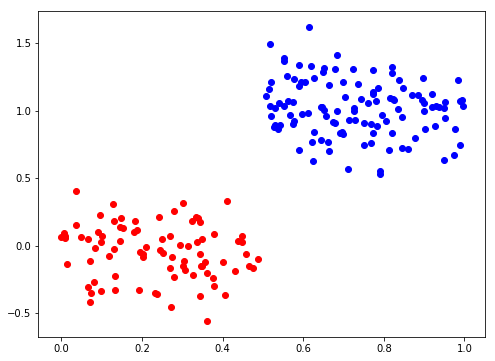

In [7]:
mat0, mat1 = binSplitDataSet(myMat, 0, 0.48813)
mat0 = np.array(mat0)
mat1 = np.array(mat1)
plt.figure(figsize=(8, 6))
plt.scatter(mat0[:, 0], mat0[:, 1], c='r')
plt.scatter(mat1[:, 0], mat1[:, 1], c='b')
plt.show()

In [8]:
myDat1 = loadDataSet('ex0.txt')
myMat1 = np.mat(myDat1)
createTree(myMat1)

{'spInd': 1,
 'spVal': 0.39435,
 'left': {'spInd': 1,
  'spVal': 0.197834,
  'left': -0.023838155555555553,
  'right': 1.0289583666666666},
 'right': {'spInd': 1,
  'spVal': 0.582002,
  'left': 1.980035071428571,
  'right': {'spInd': 1,
   'spVal': 0.797583,
   'left': 2.9836209534883724,
   'right': 3.9871632}}}

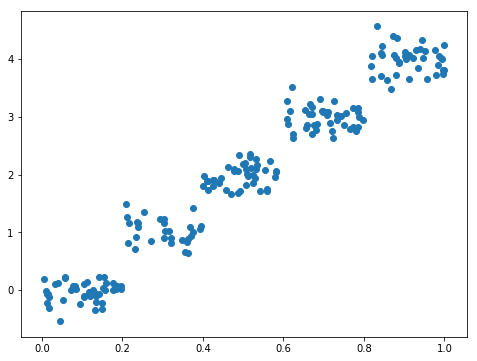

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(np.array(myMat1[:, 1]), np.array(myMat1[:, 2]))
plt.show()

## 2. 树剪枝
一棵树如果节点过多，那么可能出现了过拟合，需要降低树的复杂度来避免过拟合，这个过程就是剪枝。<br>
前面chooseBestSplit函数的停止条件就是一种预剪枝操作，还有一种叫做后剪枝。

### a. 预剪枝

In [10]:
createTree(myMat, ops=(0, 1))

{'spInd': 0,
 'spVal': 0.48813,
 'left': {'spInd': 0,
  'spVal': 0.343479,
  'left': {'spInd': 0,
   'spVal': 0.325412,
   'left': {'spInd': 0,
    'spVal': 0.048014,
    'left': {'spInd': 0,
     'spVal': 0.014083,
     'left': {'spInd': 0,
      'spVal': 0.009849,
      'left': {'spInd': 0,
       'spVal': 0.008307,
       'left': {'spInd': 0,
        'spVal': 0.000234,
        'left': 0.060903,
        'right': {'spInd': 0,
         'spVal': 0.007044,
         'left': 0.09415,
         'right': 0.069976}},
       'right': 0.056594},
      'right': -0.132525},
     'right': {'spInd': 0,
      'spVal': 0.036492,
      'left': {'spInd': 0,
       'spVal': 0.036098,
       'left': 0.155096,
       'right': 0.408155},
      'right': 0.064496}},
    'right': {'spInd': 0,
     'spVal': 0.081931,
     'left': {'spInd': 0,
      'spVal': 0.071769,
      'left': {'spInd': 0,
       'spVal': 0.065615,
       'left': -0.30697,
       'right': {'spInd': 0,
        'spVal': 0.066172,
        'lef

In [11]:
myDat2 = loadDataSet('ex2.txt')
myMat2 = np.mat(myDat2)
createTree(myMat2)

{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.457563,
  'left': {'spInd': 0,
   'spVal': 0.126833,
   'left': {'spInd': 0,
    'spVal': 0.084661,
    'left': {'spInd': 0,
     'spVal': 0.044737,
     'left': 4.091626,
     'right': -2.544392714285715},
    'right': 6.509843285714284},
   'right': {'spInd': 0,
    'spVal': 0.373501,
    'left': {'spInd': 0,
     'spVal': 0.335182,
     'left': {'spInd': 0,
      'spVal': 0.324274,
      'left': {'spInd': 0,
       'spVal': 0.297107,
       'left': {'spInd': 0,
        'spVal': 0.166765,
        'left': {'spInd': 0,
         'spVal': 0.156067,
         'left': -6.247900000000001,
         'right': -12.1079725},
        'right': {'spInd': 0,
         'spVal': 0.202161,
         'left': 3.4496025,
         'right': {'spInd': 0,
          'spVal': 0.217214,
          'left': -11.822278500000001,
          'right': {'spInd': 0,
           'spVal': 0.228473,
           'left': 6.770429,
           'right': {'spInd': 0,
 

从上面可以看出，修改了ops停止条件后，树的叶结点明显增多，发生了过拟合。当然我们可以通过调整ops的值来调整生成树的复杂度，但是这并不是一个很好的方法。事实上，我们常常不确定到底要寻找什么样的结果。这就有了后剪枝。

### b. 后剪枝
使用后剪枝需要将数据集分为训练集和测试集，首先要构造出一个具有足够复杂度的树，然后自上而下找到叶结点，用测试集判断合并叶结点后能否降低误差。

In [12]:
def isTree(obj):
    """用来测试输入是否为一个树"""
    return (type(obj).__name__ == 'dict')

def getMean(tree):
    """从上往下遍历树，如果找到叶结点就计算平均值
       对树进行塌陷处理，即返回树的平均值
    """
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['left'] + tree['right']) / 2.0

def prune(tree, testData):
    """
    从上而下找到叶结点，用测试数据集来判断将这些叶结点合并是否可以降低测试误差
    
    Parameters
    -----------
        tree :      待剪枝的树
        testData :  剪枝所需要的测试数据
    Returns
    -----------
        tree :      剪枝完成的树
    """
    # 判断测试数据集是否没有数据，如果没有，返回树本身的均值。递归的停止条件
    if testData.shape[0] == 0:
        return getMean(tree)
    
    # 判断分枝是否为子树，如果是就将测试数据集切分
    if (isTree(tree['right']) or isTree(tree['left'])):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    # 如果左边为子树，就传入左边的测试数据集和左边的分枝进行递归剪枝
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'], rSet)
    # 上面一系列操作本质上就是将测试数据集按照训练完成的树拆分完成，对应的值放到对应的节点
    
    # 如果两边都已经到达叶节点，分割测试数据集进行误差测试
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        # 计算不合并叶节点的总方差
        # 左边叶节点的平方误差加上右边叶节点的平方误差
        errorNoMerge = np.sum(np.power(lSet[:, -1] - tree['left'], 2)) + \
                       np.sum(np.power(rSet[:, -1] - tree['right'], 2))
        treeMean = (tree['left'] + tree['right']) / 2.0
        # 计算合并后的误差
        errorMerge = np.sum(np.power(testData[:, -1] - treeMean, 2))
        # 如果合并后误差 < 合并前误差，那么进行合并，以均值作为两个叶节点合并后的值
        if errorMerge < errorNoMerge:
            print("Mergeing")
            return treeMean
        else:
            return tree
    else: return tree

In [13]:
myTree = createTree(myMat2, ops=(0, 1))

In [14]:
myDatTest = loadDataSet('ex2test.txt')
myMat2Test = np.mat(myDatTest)
prune(myTree, myMat2Test)

Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing
Mergeing


{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.457563,
  'left': {'spInd': 0,
   'spVal': 0.455761,
   'left': {'spInd': 0,
    'spVal': 0.126833,
    'left': {'spInd': 0,
     'spVal': 0.124723,
     'left': {'spInd': 0,
      'spVal': 0.085111,
      'left': {'spInd': 0,
       'spVal': 0.084661,
       'left': {'spInd': 0,
        'spVal': 0.080061,
        'left': {'spInd': 0,
         'spVal': 0.068373,
         'left': {'spInd': 0,
          'spVal': 0.061219,
          'left': {'spInd': 0,
           'spVal': 0.044737,
           'left': 4.091626,
           'right': {'spInd': 0,
            'spVal': 0.053764,
            'left': -13.731698,
            'right': {'spInd': 0,
             'spVal': 0.055862,
             'left': -3.131497,
             'right': 6.695567}}},
          'right': -15.160836},
         'right': 15.824970500000001},
        'right': -24.132226},
       'right': 37.820659},
      'right': {'spInd': 0,
       'spVal': 0.108801,
      

## 3. 模型树
用树来建模除了把叶节点设为常数外，还可以把叶节点设定为分段线性函数。

In [15]:
def linearSolve(dataSet):
    """
    用来执行简单的线性回归
    """
    
    m, n = dataSet.shape
    X = np.mat(np.ones((m, n)))
    Y = np.mat(np.ones((m, 1)))
    X[:, 1:n] = dataSet[:, 0:n-1]; Y = dataSet[:, -1]
    xTx = X.T * X
    if np.linalg.det(xTx) == 0.0:
        raise NameError("This matrix is singular, cannot doo inverse.\n\
                         try increasing the second value of ops")
    ws = xTx.I * (X.T * Y)
    return ws, X, Y

def modelLeaf(dataSet):
    """
    和上面regLeaf一样，返回叶节点，不过不是一个数值，而是一个线性模型的回归系数
    """
    ws, X, Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet):
    """
    计算叶节点上的平方误差
    """
    
    ws, X, Y = linearSolve(dataSet)
    yHat = X * ws
    return np.sum(np.power(Y - yHat, 2))

In [16]:
myMat3 = np.mat(loadDataSet('exp2.txt'))
myTree = createTree(myMat3, modelLeaf, modelErr, (1, 10))
print(myTree)

{'spInd': 0, 'spVal': 0.285477, 'left': matrix([[3.46877936],
        [1.18521743]]), 'right': matrix([[1.69855694e-03],
        [1.19647739e+01]])}


可以看到上面的输出结果中叶子节点为回归系数ws的值。以0.285477为界分为了两条直线，绘图如下：

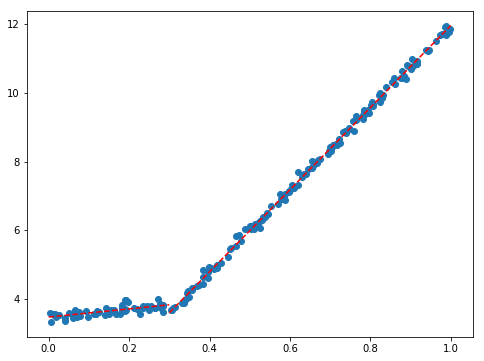

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(np.array(myMat3[:, 0]), np.array(myMat3[:, 1]))
ws1 = np.array(myTree['left'])
ws2 = np.array(myTree['right'])
xx1 = np.linspace(0, 0.3, 50)
plt.plot(xx1, ws1[1] * xx1 + ws1[0], 'r--')
xx2 = np.linspace(0.3, 1.0, 100)
plt.plot(xx2, ws2[1] * xx2 + ws2[0], 'r--')
plt.show()

从上图可以很清楚看到是一个分段模型，而模型树拟合的结果是两个线性模型：y=3.468+1.1852x 和 y=0.001 6985+11.96477x。而该数据是由y=3.5+1.0x 和 y=0+12x 再加上高斯噪声生成的。

## 4. 树回归与标准回归的比较
    前面介绍了模型树、回归树和一般的回归方法,下面测试一下哪个模型最好。本节首先给出一些函数,它们可以在树构建好的情况下对给定的输入进行预测,之后利用这些函数来计算三种回归模型的测试误差。这些模型将在某个数据上进行测试,该数据涉及人的智力水平和自行车的速度的关系。
    这里的数据是非线性的,不能简单地使用第8章的全局线性模型建模。当然这里也需要声明一下,此数据纯属虚构。

In [18]:
def regTreeEval(model, inDat):
    """
    回归树预测返回值
    """
    
    return float(model)

def modelTreeEval(model, inDat):
    """
    模型树预测返回值
    """
    
    n = inDat.shape[1]
    X = np.mat(np.ones((1, n+1)))
    X[:, 1:n+1] = inDat
    return float(X * model)

def treeForeCast(tree, inData, modelEval=regTreeEval):
    """
    自顶向下遍历整棵树，获得测试样本inData的预测值
    """
    
    if not isTree(tree):
        return modelEval(tree, inData)
    if inData[tree['spInd']] <= tree['spVal']:
        if isTree(tree['left']):
            return treeForeCast(tree['left'], inData, modelEval)
        else:
            return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'], inData, modelEval)
        else:
            return modelEval(tree['right'], inData)
        
def createForeCast(tree, testData, modelEval=regTreeEval):
    """
    使用treeForeCast预测一组向量输入值
    """
    
    m = len(testData)
    yHat = np.mat(np.zeros((m, 1)))
    for i in range(m):
        yHat[i, 0] = treeForeCast(tree, np.mat(testData[i]), modelEval)
    return yHat

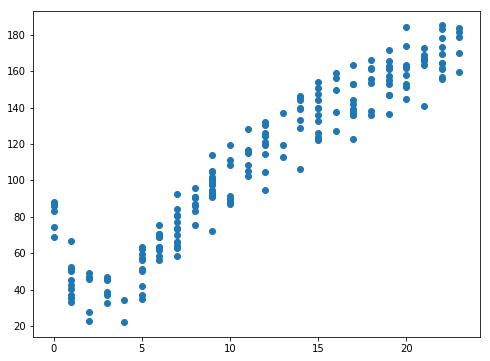

In [19]:
# 读取数据并绘制图像
trainMat = np.mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat = np.mat(loadDataSet('bikeSpeedVsIq_test.txt'))
plt.figure(figsize=(8, 6))
plt.scatter(np.array(trainMat[:, 0]), np.array(trainMat[:, 1]))
plt.show()

In [20]:
# 创建一棵回归树
myTree = createTree(trainMat, ops=(1, 20))
yHat = createForeCast(myTree, testMat[:, 0])
# corrcoef计算相关系数矩阵， 可以看到两者的相关程度，就是R^2值
np.corrcoef(yHat, testMat[:, 1], rowvar=0)[0, 1]

0.9640852318222141

In [21]:
# 创建一棵模型树
myTree = createTree(trainMat, modelLeaf, modelErr, (1, 20))
yHat = createForeCast(myTree, testMat[:, 0], modelTreeEval)
np.corrcoef(yHat, testMat[:, 1], rowvar=0)[0, 1]

0.9760412191380593

从上面可以看出模型树的相关系数较大，效果较好。

In [22]:
# 简单线性回归
ws, X, Y = linearSolve(trainMat)
ws

matrix([[37.58916794],
        [ 6.18978355]])

In [23]:
for i in range(testMat.shape[0]):
    yHat[i] = testMat[i, 0] * ws[1, 0] + ws[0, 0]
np.corrcoef(yHat, testMat[:, 1], rowvar=0)[0, 1]

0.9434684235674763

从上面可以看出简单线性回归的测试结果是最差的。

## 5. 使用Python的Tkinter库创建GUI
利用GUI对回归树调优
> 1. 收集数据:所提供的文本文件。
> 2. 准备数据:用Python解析上述文件,得到数值型数据。
> 3. 分析数据:用Tkinter构建一个GUI来展示模型和数据。
> 4. 训练算法:训练一棵回归树和一棵模型树,并与数据集一起展示出来。
> 5. 测试算法:这里不需要测试过程。
> 6. 使用算法:GUI使得人们可以在预剪枝时测试不同参数的影响,还可以帮助我们选择模型的类型。

In [25]:
from tkinter import *
import matplotlib
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

In [26]:
def reDraw(tolS, tolN):
    reDraw.f.clf()
    reDraw.a = reDraw.f.add_subplot(111)
    # 检查复选框是否被选中
    if chkBtnVar.get():
        if tolN < 2:
            tolN = 2
        myTree = createTree(reDraw.rawDat, modelLeaf, modelErr, (tolS, tolN))
        yHat = createForeCast(myTree, reDraw.testDat, modelTreeEval)
    else:
        myTree = createTree(reDraw.rawDat, ops=(tolS, tolN))
        yHat = createForeCast(myTree, reDraw.testDat)
    # 绘制数据点阵图
    reDraw.a.scatter(np.array(reDraw.rawDat[:, 0]), np.array(reDraw.rawDat[:, 1]), s=5)
    reDraw.a.plot(reDraw.testDat, yHat, linewidth=2.0, c='red')
    reDraw.canvas.show()
    
def getInputs():
    try:
        tolN = int(tolNentry.get())
    except:
        tolN = 10
        print("enter Integer for tolN")
        tolNentry.delete(0, END)
        tolNentry.insert(0, '10')
    try:
        tolS = float(tolSentry.get())
    except:
        tolS = 1.0
        print("enter Float for tolS")
        tolSentry.delete(0, END)
        tolSentry.insert(0, '1.0')
    return tolN, tolS

def drawNewTree():
    tolN, tolS = getInputs()
    reDraw(tolS, tolN)

In [27]:
root = Tk()

# 标题
Label(root, text="Plot Place Holder").grid(row=0, columnspan=3)
# 输入栏1，叶子数量
Label(root, text="tolN").grid(row=1, column=0)
tolNentry = Entry(root)
tolNentry.grid(row=1, column=1)
# 设置默认输入值
tolNentry.insert(0, '10')

# 输入栏2，容许的误差值
Label(root, text="tolS").grid(row=2, column=0)
tolSentry = Entry(root)
tolSentry.grid(row=2, column=1)
tolSentry.insert(0, '1.0')

# 创建重绘按钮
Button(root, text="ReDraw", command=drawNewTree).grid(row=1, column=2, rowspan=3)
# 设置复选框按钮，默认为回归树，勾选复选框可以选择模型树
chkBtnVar = IntVar()
chkBtn = Checkbutton(root, text="Model Tree", variable=chkBtnVar)
chkBtn.grid(row=3, column=0, columnspan=2)

# 创建一个面板，canvas
reDraw.f = Figure(figsize=(5, 4), dpi=100)
reDraw.canvas = FigureCanvasTkAgg(reDraw.f, master=root)
reDraw.canvas.show()
reDraw.canvas.get_tk_widget().grid(row=0, columnspan=3)
reDraw.rawDat = np.mat(loadDataSet('sine.txt'))
reDraw.testDat = np.arange(min(reDraw.rawDat[:, 0]), max(reDraw.rawDat[:, 0]), 0.01)
reDraw(1.0, 10)

root.mainloop()

/home/tuser/Software/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The FigureCanvasTk.show function was deprecated in version 2.2. Use FigureCanvasTk.draw instead.
/home/tuser/Software/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The FigureCanvasTk.show function was deprecated in version 2.2. Use FigureCanvasTk.draw instead.
  app.launch_new_instance()
